In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

## Create data from power spectrum

This function is set up to create a single Lorentzian peak and will be used to create several "modes". The mode height and central frequency will be set by the factor $i$ relative to the other input parameters. The mode height will be reduced by a factor $i^2$, and the central freuqency will be shifted by a factor $i$.

In [327]:
def single_lorentzian(x, x_0, A, width, i):
    model = ((2*A**2 / (np.pi*width*i**2)) / (1 + (2*(x-i*x_0) / width)**2))
    return model

Here we create and plot the power spectrum of the artificial data, to have a peak at the 27-rotation period ($\nu_0$) with 4 harmonics $n \, \nu_0$ for n in range 2-5.

Power = 141009583.57136396


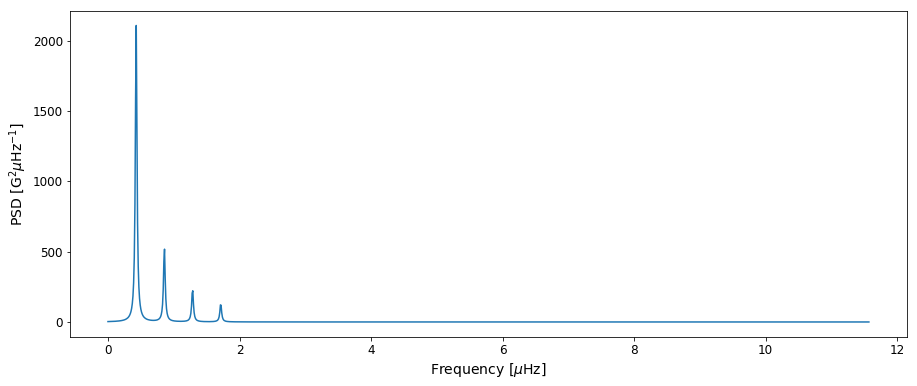

Peak at nu_0 = 0.43 muHz


In [339]:
dx = 0.01 # Resolution 0.01 muHz (1158 days ~= 3 yrs)
x = np.arange(0, (1*1e6/(3600*24)), dx) # Nyquist = 1 day 
x_0 = (1e6/(3600*24*27)) # Central frequency of fundamental peak (i.e. 27-day peak ~= 0.43 muHz)
A = 10 # Amplitude of fundamental peak [G]
width = 0.03 # Width [muHz]

powers = [single_lorentzian(x, x_0, A, width, i) for i in np.arange(1,5)] # Create peak(s)
powers = np.sum(powers, axis=0) # Sum single peak(s) together into one power spectrum
print("Power = %s"%(np.sum(powers * dx * 1e6)))
powers = powers + 1 # Add a bkgnd level of 1

# Plot peaks
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Frequency [$\mu$Hz]', fontsize=14)
ax.set_ylabel('PSD [G$^2$$\mu$Hz$^{-1}$]', fontsize=14)
ax.tick_params(labelsize=12)
ax.plot(x, powers)
plt.show()

print("Peak at nu_0 = %s muHz"%x[np.argmax(powers)])

Now we need to convert the signal from PSD into amplitude ($A(f(k))$): $A(f(k)) \, = \, \sqrt{2 \,\mathrm{PSD}}$

BUT - first need to go from PSD in units [G$^2$$\mu$Hz$^{-1}$] into [G$^2$]

Then to convert from amplitude to the frequency domain signal ($Z(f(k))$): $Z(f(k)) \, = \, A(f(k)) \, e^{i \phi(f(k)))}$, where $\phi(f(k))$ is some random phase supplied to the signal between $0$ and $2\pi$.

In [90]:
#powers *= dx*1e6 # Change into units [G^2]

Time series length: 1158
(1158,) 1158 1158
[-0.34189363  0.82427375  0.62997384 ...  6.04766486  7.13773517
  2.57543973]


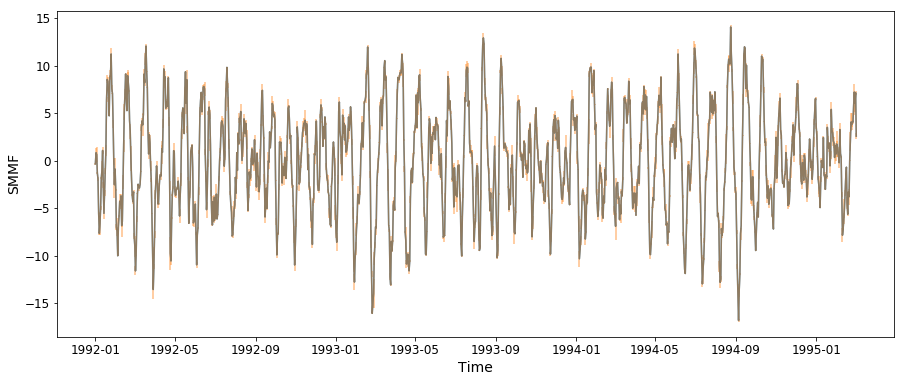

Time-series real component variance: 29.095338325129806


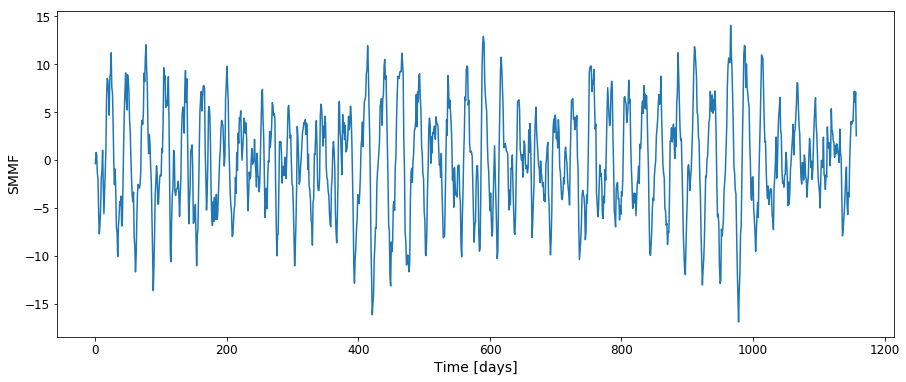

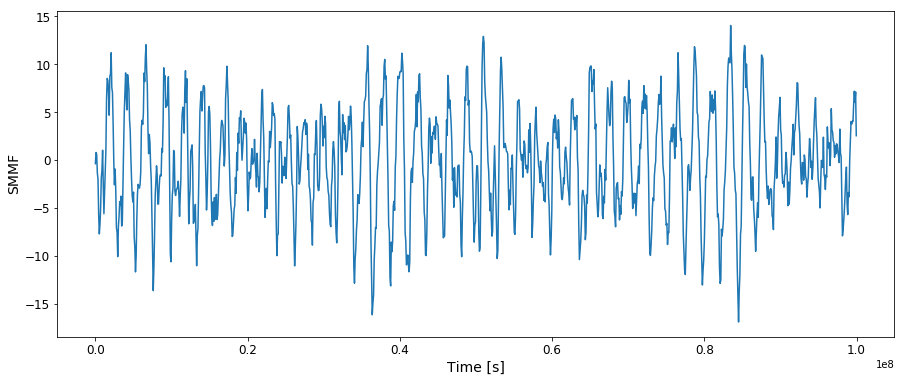

In [347]:
amplitudes = np.sqrt(powers) # Compute amplitudes from powers
phases = np.random.uniform(0, 2*np.pi, len(amplitudes)) # Generate random phases
freq_sigs = [a*np.exp(1j*p) for a,p in zip (amplitudes, phases)] # Conversion to frequency domain signal
time_series = np.fft.ifft(freq_sigs) # Compute discrete FFT (probably not correct!)
t = np.arange(len(time_series)) # Time array [days]
ts = t * (24*3600) # Time array [s]
print('Time series length: %s'%(len(time_series)))

noise = np.fft.fft(np.random.randn(len(powers)))
amp_spec = noise * np.sqrt(powers)
time_series = np.fft.irfft(amp_spec, n=len(powers))
print(noise.shape, len(powers), len(time_series))
print(time_series)
# Put the time series into a pandas DataFramd with the index as time since 01/01/1992
df = pd.DataFrame({'SMMF':time_series.real}, 
                      index=[datetime.datetime(1992,1,1) + datetime.timedelta(days=int(ti)) for ti in t])

# Plot time series
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('SMMF', fontsize=14)
ax.tick_params(labelsize=12)
ax.plot(df.index.values, df['SMMF'])

yerr = np.random.normal(0, 0.5, len(time_series))
ax.errorbar(df.index.values, df['SMMF'], abs(yerr), alpha=0.5)
plt.show()

# Plot time series
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Time [days]', fontsize=14)
ax.set_ylabel('SMMF', fontsize=14)
ax.tick_params(labelsize=12)
ax.plot(t, df['SMMF'])

# Plot time series
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Time [s]', fontsize=14)
ax.set_ylabel('SMMF', fontsize=14)
ax.tick_params(labelsize=12)
ax.plot(ts, df['SMMF'])


print('Time-series real component variance: %s'%(np.std(time_series.real)**2))

Now we should re-do the FFT to ensure that the PSD comes out the same as what we started with.

Begin FFT...
Pre-mask times length: 1158
Fill is: 1.0
Post-mask times length: 1158
TS_var: 29.095338325129806
FD: 29.119091620404895


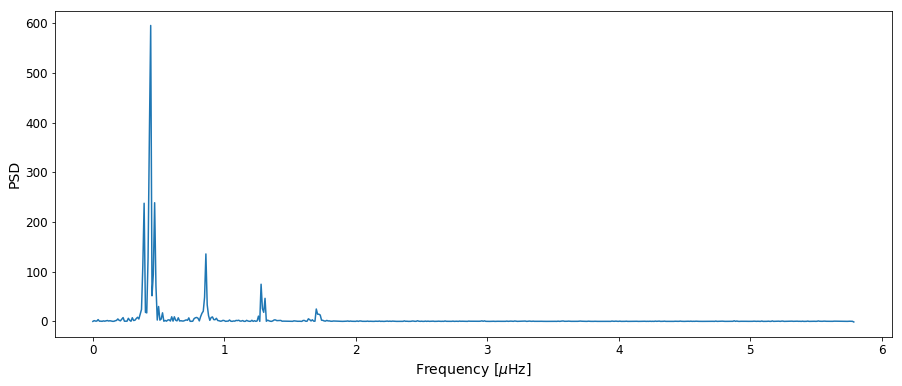

Time-series variance: 29.095338325129806
Peak at nu_0 = 0.43977483528433436 muHz


In [348]:
import timeseries_FFT

def FFT(start, end, data = None, oversample = False, plot=False):
    print('Begin FFT...')
    # data = self.Vn_df[0] # set FFT data
    data = data
    error = data*0.0001

    f = timeseries_FFT.timeseries_FFT_plot(data, error, start, end, 'SMMF [G]', 'PSD [$G^2$$\mu$Hz$^{-1}$]', maj_tick = .5, min_tick=.05)
    freqs, power, times = f.FT_data()
    if plot == True:
        f.make_plot()
    return freqs, power, times

# Re-compute the power spectrum
freqs, power, times = FFT(start = pd.to_datetime(df.index.values[0]), end = pd.to_datetime(df.index.values[-1]), data = df['SMMF'], plot=False, oversample=False)

# Plot power re-calculated power spectrum
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Frequency [$\mu$Hz]', fontsize=14)
ax.set_ylabel('PSD', fontsize=14)
ax.tick_params(labelsize=12)
ax.plot(freqs, power)
plt.show()

print('Time-series variance: %s'%(np.std(df['SMMF'])**2))
print("Peak at nu_0 = %s muHz"%freqs[np.argmax(power)])

This looks ok... the y-axis values are different to those used during the input which should be checked... it could be a mixture of units/mistakes in going from PSD->AMP->TS/general errors that have caused this difference.

The new nyquist is half the original frequency grid, due to the way that I set up the frequency grid initially, but expect this to be $\frac{1}{2 dT}$, whdre $dT$ is the sampling in the time domain (i.e. 0.5 * (1/day)) ~= 5.75 muHz.

## Celerite model

Now we will try to model the time-series using a GP.

Note that we assume Q-factor: $Q \, = \, \frac{\nu_0}{\Gamma}$

In [349]:
import celerite
from celerite import terms
from celerite.modeling import Model

"""
# A real-term
bounds = dict(log_a=(0, 15), log_c=(-15, 15))
kernel = terms.RealTerm(log_a=np.log(10), log_c=-np.log(1.0), bounds=bounds)


# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = 0.01
#bounds = dict(log_S0=(-15, 20), log_Q=(-15, 15), log_omega0=(-20, 15))
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term
"""

# Jitter Term
bounds = dict(log_sigma=(-15, 15))
kernel = terms.JitterTerm(log_sigma=np.log(0.5), bounds=bounds)

# A periodic component for fundamental harmonic peak
#bounds = dict(log_S0=(-10, 30), log_Q=(-20, 20), log_omega0=(-20, 15))
bounds = dict(log_S0=(-5, 5), log_Q=(-4, 4), log_omega0=(-3, -1))
Q = 10
#w0 = (1.0 / 27.0 / 2.0 / np.pi)
w0 = 2.0 * np.pi * (1.0 / 27.0)
S0 = np.var(df.SMMF.values) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

#"""
# A 2nd periodic component for 2nd harmonic
#bounds = dict(log_S0=(-10, 30), log_Q=(-20, 20), log_omega0=(-20, 15))
bounds = dict(log_S0=(-15, 15), log_Q=(-5, 5), log_omega0=(-1, -0.5))
Q = 10
#w0 = (1.0 / 27.0 / 2.0 / np.pi)
w0 = 2 * 2.0 * np.pi * (1.0 / 27.0)
S0 = np.var(df.SMMF.values) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

# A 2nd periodic component for 3rd harmonic
#bounds = dict(log_S0=(-10, 30), log_Q=(-20, 20), log_omega0=(-20, 15))
bounds = dict(log_S0=(-15, 15), log_Q=(-5, 5), log_omega0=(-0.5, -0.2))
Q = 10
#w0 = (1.0 / 27.0 / 2.0 / np.pi)
w0 = 3 * 2.0 * np.pi * (1.0 / 27.0)
S0 = np.var(df.SMMF.values) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

# A 2nd periodic component for 4th harmonic
#bounds = dict(log_S0=(-10, 30), log_Q=(-20, 20), log_omega0=(-20, 15))
bounds = dict(log_S0=(-15, 15), log_Q=(-5, 5), log_omega0=(-0.2, 0))
Q = 10
#w0 = (1.0 / 27.0 / 2.0 / np.pi)
w0 = 4 * 2.0 * np.pi * (1.0 / 27.0)
S0 = np.var(df.SMMF.values) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)
#"""

# Define the model
class MeanModel(Model):
    parameter_names = ("A", "P")

    def get_value(self, t):
        return self.A * np.sin(2.0 * np.pi * t / self.P)
    
# Create and compute GP
gp = celerite.GP(kernel, mean=np.mean(df.SMMF.values), fit_mean=False)
gp.compute(t, yerr)  # Always need to call compute once
print("Initial log likelihood: %.6f"%(gp.log_likelihood(df['SMMF'].values)))
print(gp.get_parameter_vector())

Initial log likelihood: -2790.137806
[-0.69314718  2.52595267  2.30258509 -1.4579598   1.83280549  2.30258509
 -0.76481262  1.42734038  2.30258509 -0.35934751  1.13965831  2.30258509
 -0.07166544]


Create likelihood function for emcee to work with

In [350]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    #if params[0] < 0:
    #    return -np.inf
    return gp.log_likelihood(df['SMMF'].values) + lp

Run emcee on this

In [351]:
import emcee

initial = gp.get_parameter_vector()
print(initial)
print(log_probability(initial))

ndim, nwalkers = len(initial), 50
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, a=4)

import time
start_time = time.time()

print("Running burn-in...")
p0 = initial + 1e-3 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 3000)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 3000);

print("We're done here...")
print("... elapsed_time = %.6f s"%(time.time() - start_time))

print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

print(gp.get_parameter_vector())

[-0.69314718  2.52595267  2.30258509 -1.4579598   1.83280549  2.30258509
 -0.76481262  1.42734038  2.30258509 -0.35934751  1.13965831  2.30258509
 -0.07166544]
-2790.1378055986197
Running burn-in...
Running production...
We're done here...
... elapsed_time = 196.158937 s
Mean acceptance fraction: 0.167
[-0.12770336  1.3669295   4.34164066 -1.46916782 -0.57838527  1.27235462
 -0.72881605 -2.37380339  1.82423561 -0.31826133 -4.07661649  3.68385811
 -0.07490652]


(150000, 13)


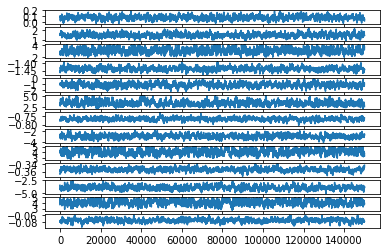

In [352]:
nparams = len(initial)
sam = sampler.flatchain
exp_sam = np.exp(sam)
print(np.shape(sam))
fig, ax = plt.subplots(nparams)
for i in range(nparams):
    ax[i].plot(sam[:, i])

Import and plot corner.

$\sigma$ units: TBC

$S_0$ units: TBC

$Q_0$ units: unitless

$\omega$ units: rad/day

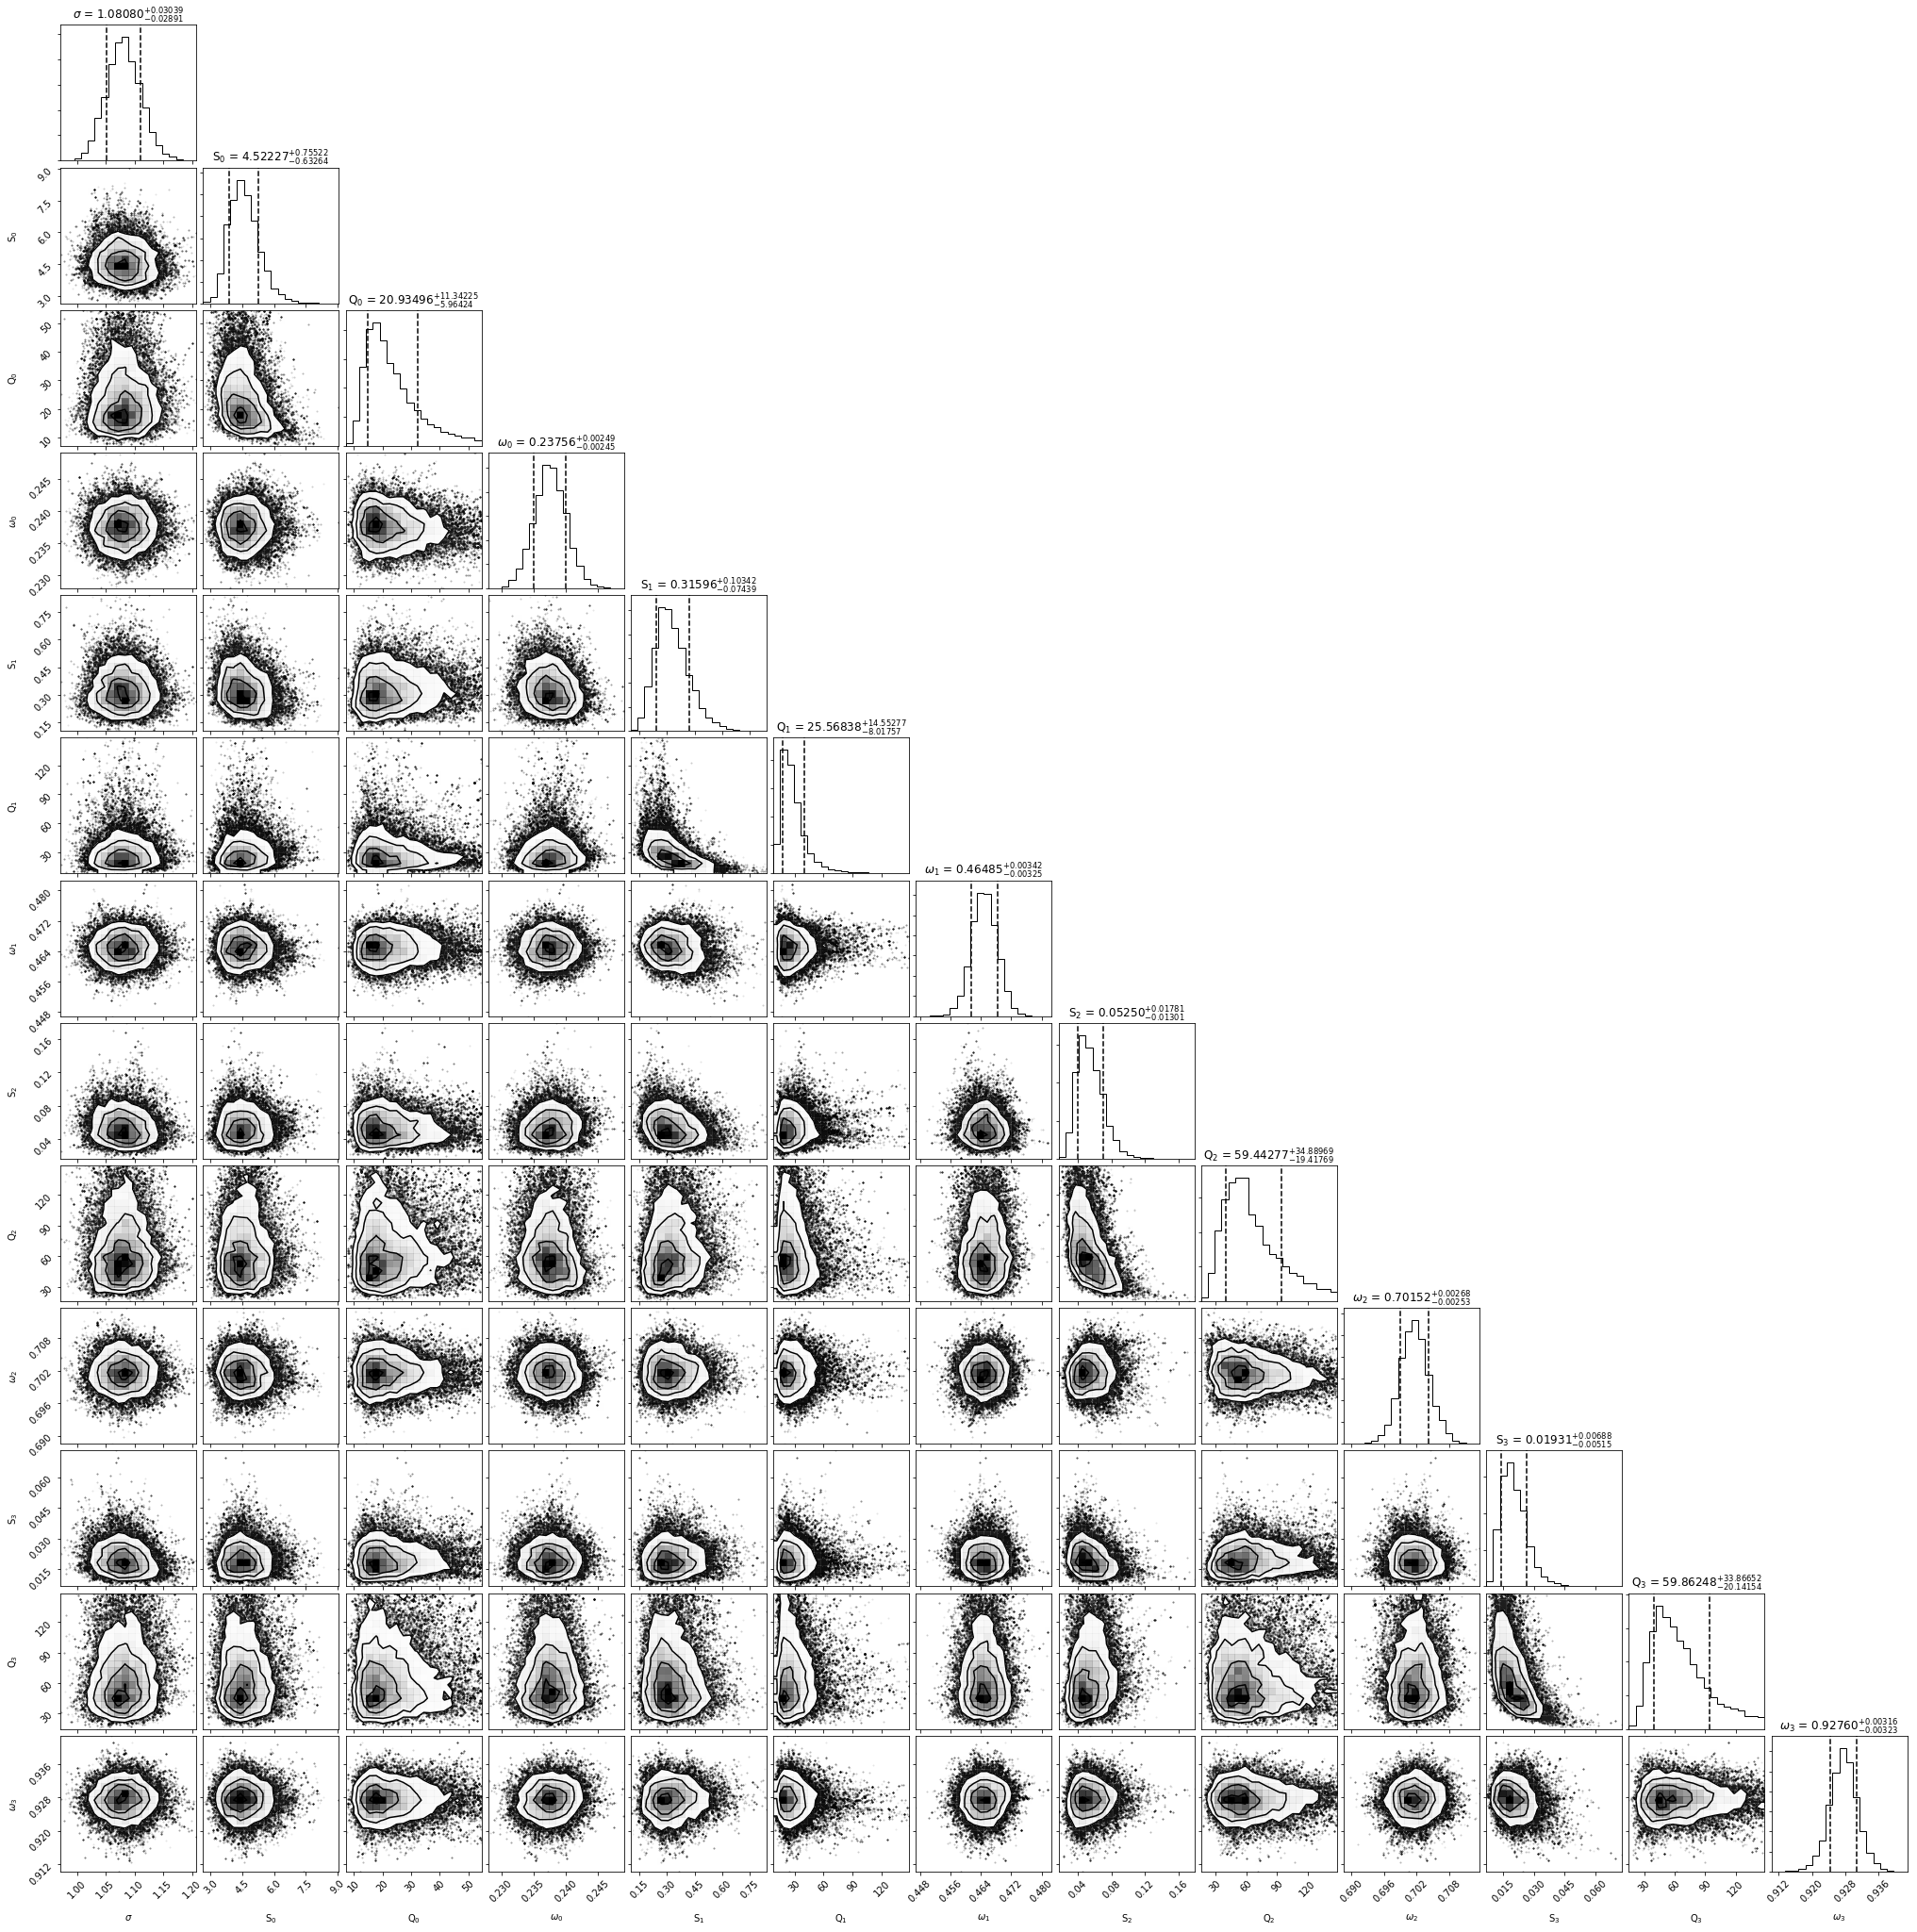

[8.80114414e-01 3.92328575e+00 7.68334937e+01 2.30116904e-01
 5.60803183e-01 3.56924689e+00 4.82479886e-01 9.31258583e-02
 6.19805550e+00 7.27412666e-01 1.69647691e-02 3.97996496e+01
 9.27830219e-01]


In [356]:
import corner
sam
corner.corner(exp_sam,
                show_titles = True,
                labels = ["$\\sigma$", "S$_0$", "Q$_0$", "$\\omega_0$", "S$_1$", "Q$_1$", "$\\omega_1$", "S$_2$", "Q$_2$", "$\\omega_2$", "S$_3$", "Q$_3$", "$\\omega_3$"],
                quantiles = [0.5-0.3413, 0.5+0.3413], 
                title_fmt='.5f')
plt.show()
print(np.exp(gp.get_parameter_vector()))
#print("Period: %.6e"%model.P)
#print("Amplitude: %.6e"%model.A)

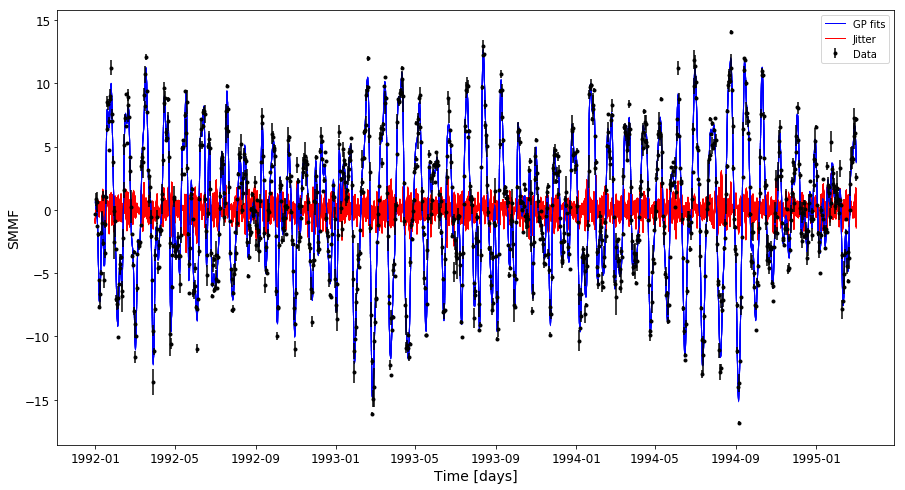

In [359]:
# Plot the data.
fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel('Time [days]', fontsize=14)
ax.set_ylabel('SMMF', fontsize=14)
ax.tick_params(labelsize=12)

ax.errorbar(df.index.values, df['SMMF'].values, yerr=yerr, fmt=".k", capsize=0, label='Data', zorder=3)

#lp = like(t, df['SMMF'].values, yerr)
# Plot GP samples.
#samples = sampler.flatchain
itn = 0
for s in sam[np.random.randint(len(sam), size=53)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(df['SMMF'].values, t, return_cov=False)
    if itn == 0:
        a = ax.plot(df.index.values, mu, color='b', alpha=1, lw=1.0, label='GP fits', zorder=2)
        b = ax.plot(df.index.values, df['SMMF'].values - mu, color='r', alpha=1, lw=1.0, label='Jitter', zorder=1)
        itn+=1
    else:
        a = ax.plot(df.index.values, mu, color='b', alpha=0.1, lw=1.0, zorder=2)
        b = ax.plot(df.index.values, df['SMMF'].values - mu, color='r', alpha=1, lw=1.0, zorder=1)

ax.legend()

#ax.plot(df.index.values, model.get_value(t))

#ax.plot(df.index.values, 5*np.sin(0.43*t))